In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import os
from torchvision import datasets

In [2]:
data_dir = "/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
indices = list(range(len(full_dataset)))

In [3]:
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Identity() 
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

def extract_features(loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(inputs)
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

accuracies = {
    "MobileNetV2_KNN": {"train": [], "test": []},
    "MobileNetV2_SVM": {"train": [], "test": []},
    "MobileNetV2_RF": {"train": [], "test": []}
}


dataper = [0.01, 0.1, 0.5, 0.7]
for i in dataper:
    train_idx, test_idx = train_test_split(indices, train_size=i, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.8, random_state=42)

    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Train set: {len(train_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")

    # Extract features
    train_features, train_labels = extract_features(train_loader)
    test_features, test_labels = extract_features(test_loader)

    # Classifiers
    classifiers = {
        "MobileNetV2_KNN": KNeighborsClassifier(n_neighbors=3),
        "MobileNetV2_SVM": SVC(kernel='linear'),
        "MobileNetV2_RF": RandomForestClassifier(n_estimators=100)
    }

    for name, clf in classifiers.items():
        # Train the classifier
        clf.fit(train_features, train_labels)
        print(f"Comlpeted Training on {i*100} % data")
        # Train accuracy
        train_preds = clf.predict(train_features)
        train_acc = accuracy_score(train_labels, train_preds)
        accuracies[name]["train"].append(round(train_acc * 100, 2))
        print(f"Train accuracies found on {i*100} % data")
        # Test accuracy
        test_preds = clf.predict(test_features)
        test_acc = accuracy_score(test_labels, test_preds)
        accuracies[name]["test"].append(round(test_acc * 100, 2))
        print(f"Test accuracies found on {i*100} % data")
        
        print(f'{name} -> Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 203MB/s]


Train set: 170 images
Test set: 13538 images
Comlpeted Training on 1.0 % data
Train accuracies found on 1.0 % data
Test accuracies found on 1.0 % data
MobileNetV2_KNN -> Train Acc: 0.6412, Test Acc: 0.3932
Comlpeted Training on 1.0 % data
Train accuracies found on 1.0 % data
Test accuracies found on 1.0 % data
MobileNetV2_SVM -> Train Acc: 1.0000, Test Acc: 0.6521
Comlpeted Training on 1.0 % data
Train accuracies found on 1.0 % data
Test accuracies found on 1.0 % data
MobileNetV2_RF -> Train Acc: 1.0000, Test Acc: 0.5363
Train set: 1709 images
Test set: 12307 images
Comlpeted Training on 10.0 % data
Train accuracies found on 10.0 % data
Test accuracies found on 10.0 % data
MobileNetV2_KNN -> Train Acc: 0.7934, Test Acc: 0.5598
Comlpeted Training on 10.0 % data
Train accuracies found on 10.0 % data
Test accuracies found on 10.0 % data
MobileNetV2_SVM -> Train Acc: 1.0000, Test Acc: 0.8060
Comlpeted Training on 10.0 % data
Train accuracies found on 10.0 % data
Test accuracies found on 10

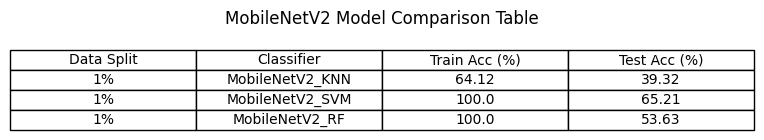

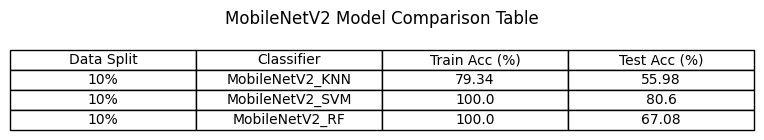

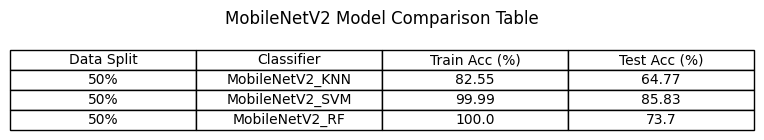

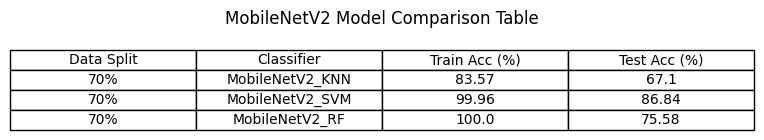

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
for i,p in enumerate(dataper):
    data = {
        'Data Split': [f'{int(p*100)}%', f'{int(p*100)}%', f'{int(p*100)}%'],
        'Classifier': ['MobileNetV2_KNN', 'MobileNetV2_SVM', 'MobileNetV2_RF'],
        'Train Acc (%)': [accuracies['MobileNetV2_KNN']['train'][i], 
                          accuracies['MobileNetV2_SVM']['train'][i], 
                          accuracies['MobileNetV2_RF']['train'][i]],
        'Test Acc (%)': [accuracies['MobileNetV2_KNN']['test'][i], 
                         accuracies['MobileNetV2_SVM']['test'][i], 
                         accuracies['MobileNetV2_RF']['test'][i]]
    }
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('tight')
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2) 
    plt.title(f'MobileNetV2 Model Comparison Table', pad=20)
    plt.show()